# Week-2 Assignment: Environment Design & Validation (RL)

This notebook focuses **only on environment design**, not training agents.

## Task 0: Imports & Seeding

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# TODO: Do not modify this cell

## Task 1: Implement the Environment (MDP)

In [14]:
class FlappyEnv:
    def __init__(self, gravity=1.0, reward_mode='dense'):
        self.gravity = float(gravity)
        self.width = 288
        self.height = 400
        self.bird_x = 50
        self.pipe_width = 52
        self.pipe_speed = 3.0
        self.gap_size = 120.0
        self.flap_strength = 8.0
        self.max_vel = 10.0
        self.reward_mode = reward_mode
        self.reset()

    def set_reward_mode(self, mode):
        self.reward_mode = mode

    def reset(self):
        self.bird_y = self.height / 2.0
        self.bird_vel = 0.0
        self.pipe_x = self.width
        margin = 40
        self.gap_y = float(np.random.randint(margin, self.height - margin))
        self.passed_current_pipe = False
        self.done = False
        return self._get_state()

    def _get_state(self):
        distance_to_pipe = self.pipe_x - self.bird_x
        gap_offset = self.bird_y - self.gap_y
        return np.array([self.bird_y, self.bird_vel, distance_to_pipe, gap_offset], dtype=np.float32)

    def _reward_from_info(self, info):
        if self.reward_mode == 'sparse':
            return sparse_reward(info)
        elif self.reward_mode == 'shaped':
            return shaped_reward(info)
        else:
            return dense_reward(info)

    def step(self, action):
        if self.done:
            return self._get_state(), 0.0, True

        if action == 1:
            self.bird_vel = -self.flap_strength
        self.bird_vel += self.gravity
        self.bird_vel = float(np.clip(self.bird_vel, -self.max_vel, self.max_vel))

        self.bird_y += self.bird_vel
        self.pipe_x -= self.pipe_speed

        done = False
        passed = False

        if self.bird_y <= 0 or self.bird_y >= self.height:
            done = True
        else:
            within_horizontal = (self.bird_x > self.pipe_x) and (self.bird_x < self.pipe_x + self.pipe_width)
            gap_top = self.gap_y + self.gap_size / 2.0
            gap_bottom = self.gap_y - self.gap_size / 2.0
            within_gap = (self.bird_y >= gap_bottom) and (self.bird_y <= gap_top)
            if within_horizontal and not within_gap:
                done = True

        if not done and not self.passed_current_pipe and (self.pipe_x + self.pipe_width) < self.bird_x:
            self.passed_current_pipe = True
            passed = True

        if (self.pipe_x + self.pipe_width) < 0:
            self.pipe_x = self.width
            margin = 40
            self.gap_y = float(np.random.randint(margin, self.height - margin))
            self.passed_current_pipe = False

        self.done = done

        s = self._get_state()
        info = {
            'dead': done,
            'passed': passed,
            'gap_offset': float(s[3]),
        }
        r = float(self._reward_from_info(info))
        return s, r, bool(done)

## Task 2: Markov Property Validation

In [15]:
def is_markov_sufficient(env, state, action=0, trials=10):
    """
    - Reset environment multiple times
    - Force the same state
    - Take the same action
    - If next states differ → return False
    - Else return True
    """
    next_states = []
    for _ in range(trials):
        env.reset()
        env.bird_y = float(state[0])
        env.bird_vel = float(state[1])
        env.pipe_x = float(env.bird_x + state[2])
        env.gap_y = float(env.bird_y - state[3])
        env.done = False
        env.passed_current_pipe = False
        s_next, _, _ = env.step(action)
        next_states.append(s_next)
    ref = next_states[0]
    for s in next_states[1:]:
        if not np.allclose(ref, s, atol=1e-6):
            return False
    return True

## Task 3: Discretization

In [16]:
def discretize_state(state):
    """
    Discretize:
    - gap_offset: below, inside, above
    - velocity: rising, slow fall, fast fall
    - distance_to_pipe: near, far
    Returns a tuple of bins (3,3,2).
    """
    bird_y, vel, dist, gap_off = state

    # Gap position bins
    if gap_off < -15:
        pos_bin = 0  # below
    elif gap_off > 15:
        pos_bin = 2  # above
    else:
        pos_bin = 1  # inside

    # Velocity bins (negative means rising)
    if vel < -2:
        vel_bin = 0  # rising
    elif vel > 4:
        vel_bin = 2  # falling fast
    else:
        vel_bin = 1  # falling slow / near zero

    # Distance bins
    dist_bin = 0 if dist < 60 else 1  # near / far

    return (pos_bin, vel_bin, dist_bin)

## Task 4: Discrete State Space Size

In [17]:
# Define bins per dimension
bins_pos = 3   # below/inside/above
bins_vel = 3   # rising/slow/fast
bins_dist = 2  # near/far

# Compute total discrete states
total_states = bins_pos * bins_vel * bins_dist
assert total_states <= 10000
print('Total discrete states:', total_states)

Total discrete states: 18


## Task 5: Reward Functions

In [10]:
def sparse_reward(info):
    """
    - +10 for passing pipe
    - -50 for death
    - 0 otherwise
    """
    if info.get('dead', False):
        return -50.0
    if info.get('passed', False):
        return 10.0
    return 0.0

def dense_reward(info):
    """
    - Small positive reward for staying alive
    - Large negative reward for death
    """
    return -50.0 if info.get('dead', False) else 0.1

def shaped_reward(info):
    """
    - Start from dense reward
    - Penalize distance from gap center slightly
    - Shaping must not dominate sparse reward
    """
    base = dense_reward(info)
    if info.get('dead', False):
        return base
    gap_offset = float(info.get('gap_offset', 0.0))
    penalty = 0.01 * abs(gap_offset)
    penalty = min(penalty, 5.0)  # cap shaping so it never dominates
    return base - penalty

## Task 6: Random Policy Validation

In [18]:
def run_random_policy(env, episodes=500):
    """
    - Run random actions
    - Track episode lengths & rewards
    - Print statistics
    - Warn if environment is too easy or too hard
    """
    lengths = []
    rewards = []
    for _ in range(episodes):
        s = env.reset()
        total = 0.0
        steps = 0
        while True:
            a = np.random.randint(0, 2)
            s, r, done = env.step(a)
            total += r
            steps += 1
            if done:
                break
        lengths.append(steps)
        rewards.append(total)

    avg_len = float(np.mean(lengths))
    avg_rew = float(np.mean(rewards))
    print(f"Episodes: {episodes}\nAvg length: {avg_len:.2f}\nAvg reward: {avg_rew:.2f}")

    if avg_len < 10:
        print("Warning: environment may be too hard for random policy.")
    if avg_len > 200:
        print("Warning: environment may be too easy for random policy.")
    return lengths, rewards

## Task 7: Environment Stress Testing

Episodes: 200
Avg length: 32.85
Avg reward: -46.81
Episodes: 200
Avg length: 34.53
Avg reward: -46.65
Episodes: 200
Avg length: 37.40
Avg reward: -46.36


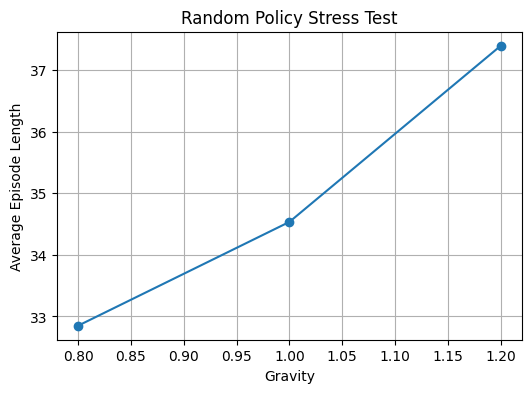

In [20]:
# Test random policy under gravity × {0.8, 1.0, 1.2}
gravities = [0.8, 1.0, 1.2]
avg_lengths = []
for g in gravities:
    env_g = FlappyEnv(gravity=g)
    lengths, _ = run_random_policy(env_g, episodes=200)
    avg_lengths.append(float(np.mean(lengths)))

plt.figure(figsize=(6,4))
plt.plot(gravities, avg_lengths, marker='o')
plt.xlabel('Gravity')
plt.ylabel('Average Episode Length')
plt.title('Random Policy Stress Test')
plt.grid(True)
plt.show()

## Submission Checklist
- All TODOs implemented
- No RL training code
- Environment deterministic
- Random policy runs without crashing
- Stress test plot included